In [ ]:
import os
import re
import sys
import nltk
import json
import requests
import html5lib
import pandas as pd
import pyspark.sql.functions
import pyspark.sql.types as T
from datetime import datetime
from bs4 import BeautifulSoup
from pyspark.sql import Row
from textblob import TextBlob
from transformers import pipeline
from pyspark.sql.functions import explode, col
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

from sklearn.metrics import accuracy_score,hamming_loss,classification_report

### Split Dataset into Train and Text
from sklearn.model_selection import train_test_split
# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

#from skmultilearn.adapt import MLkNN
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import string
import neattext as nt
import neattext.functions as nfx
from sklearn.utils import shuffle
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

import ktrain
from ktrain import text

In [ ]:
pip install transformers

Python interpreter will be restarted.
Collecting transformers
 Downloading transformers-4.11.0-py3-none-any.whl (2.9 MB)
Requirement already satisfied: numpy>=1.17 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from transformers) (1.19.2)
Requirement already satisfied: tqdm>=4.27 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from transformers) (4.50.2)
Requirement already satisfied: pyyaml>=5.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from transformers) (5.4.1)
Requirement already satisfied: regex!=2019.12.17 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from transformers) (2020.10.15)
Collecting sacremoses
 Downloading sacremoses-0.0.46-py3-none-any.whl (895 kB)
Collecting filelock
 Downloading filelock-3.1.0-py2.py3-none-any.whl (8.4 kB)
Requirement already satisfied: requests in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from transformers) (2.24.0)
Collecting tokenizers<0.11,>=0.10.1
 Downloading tokenizers-0.10.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
Collecting huggingface-hub>=0.0.17
 Downloading huggingface_hub-0.0.17-py3-none-any.whl (52 kB)
Requirement already satisfied: packaging>=20.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from transformers) (20.4)
Requirement already satisfied: joblib in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from sacremoses->transformers) (0.17.0)
Requirement already satisfied: six in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from sacremoses->transformers) (1.15.0)
Requirement already satisfied: click in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from sacremoses->transformers) (7.1.2)
Requirement already satisfied: certifi>=2017.4.17 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from requests->transformers) (2021.5.30)
Requirement already satisfied: chardet<4,>=3.0.2 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from requests->transformers) (3.0.4)
Requirement already satisfied: idna<3,>=2.5 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from requests->transformers) (2.10)
Requirement already satisfied: urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from requests->transformers) (1.25.11)
Requirement already satisfied: typing-extensions in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from huggingface-hub>=0.0.17->transformers) (3.7.4.3)
Requirement already satisfied: pyparsing>=2.0.2 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from packaging>=20.0->transformers) (2.4.7)
Installing collected packages: sacremoses, filelock, tokenizers, huggingface-hub, transformers
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

huggingface-hub 0.0.17 requires packaging>=20.9, but you'll have packaging 20.4 which is incompatible.
Successfully installed filelock-3.1.0 huggingface-hub-0.0

In [ ]:
pip install TextBlob

Python interpreter will be restarted.
Collecting TextBlob
 Downloading textblob-0.15.3-py2.py3-none-any.whl (636 kB)
Requirement already satisfied: nltk>=3.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from TextBlob) (3.5)
Requirement already satisfied: regex in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from nltk>=3.1->TextBlob) (2020.10.15)
Requirement already satisfied: click in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from nltk>=3.1->TextBlob) (7.1.2)
Requirement already satisfied: joblib in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from nltk>=3.1->TextBlob) (0.17.0)
Requirement already satisfied: tqdm in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from nltk>=3.1->TextBlob) (4.50.2)
Installing collected packages: TextBlob
Successfully installed TextBlob-0.15.3
Python interpreter will be restarted.

In [ ]:
pip install bs4

Python interpreter will be restarted.
Collecting bs4
 Downloading bs4-0.0.1.tar.gz (1.1 kB)
Collecting beautifulsoup4
 Downloading beautifulsoup4-4.10.0-py3-none-any.whl (97 kB)
Collecting soupsieve>1.2
 Downloading soupsieve-2.2.1-py3-none-any.whl (33 kB)
Building wheels for collected packages: bs4
 Building wheel for bs4 (setup.py): started
 Building wheel for bs4 (setup.py): finished with status 'done'
 Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=17da391a79613b57b8c9f7b98b77cf6d360f28f4cbbd52314dcecf808df73e8b
 Stored in directory: /root/.cache/pip/wheels/75/78/21/68b124549c9bdc94f822c02fb9aa3578a669843f9767776bca
Successfully built bs4
Installing collected packages: soupsieve, beautifulsoup4, bs4
Successfully installed beautifulsoup4-4.10.0 bs4-0.0.1 soupsieve-2.2.1
Python interpreter will be restarted.

In [ ]:
pip install html5lib

Python interpreter will be restarted.
Collecting html5lib
 Downloading html5lib-1.1-py2.py3-none-any.whl (112 kB)
Requirement already satisfied: webencodings in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from html5lib) (0.5.1)
Requirement already satisfied: six>=1.9 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from html5lib) (1.15.0)
Installing collected packages: html5lib
Successfully installed html5lib-1.1
Python interpreter will be restarted.

In [ ]:
pip install neattext

Python interpreter will be restarted.
Collecting neattext
 Downloading neattext-0.1.1-py3-none-any.whl (112 kB)
Installing collected packages: neattext
Successfully installed neattext-0.1.1
Python interpreter will be restarted.

In [ ]:
pip install ktrain

Python interpreter will be restarted.
Collecting ktrain
 Downloading ktrain-0.27.3.tar.gz (25.3 MB)
Requirement already satisfied: scikit-learn==0.23.2 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from ktrain) (0.23.2)
Requirement already satisfied: matplotlib>=3.0.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from ktrain) (3.2.2)
Requirement already satisfied: pandas>=1.0.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from ktrain) (1.1.3)
Collecting fastprogress>=0.1.21
 Downloading fastprogress-1.0.0-py3-none-any.whl (12 kB)
Requirement already satisfied: requests in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from ktrain) (2.24.0)
Requirement already satisfied: joblib in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from ktrain) (0.17.0)
Requirement already satisfied: packaging in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from ktrain) (20.4)
Requirement already satisfied: ipython in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from ktrain) (7.19.0)
Collecting langdetect
 Downloading langdetect-1.0.9.tar.gz (981 kB)
Collecting jieba
 Downloading jieba-0.42.1.tar.gz (19.2 MB)
Collecting cchardet
 Downloading cchardet-2.1.7-cp38-cp38-manylinux2010_x86_64.whl (265 kB)
Requirement already satisfied: chardet in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from ktrain) (3.0.4)
Collecting syntok
 Downloading syntok-1.3.1.tar.gz (23 kB)
Collecting seqeval==0.0.19
 Downloading seqeval-0.0.19.tar.gz (30 kB)
Collecting transformers<=4.3.3,>=4.0.0
 Downloading transformers-4.3.3-py3-none-any.whl (1.9 MB)
Collecting sentencepiece
 Downloading sentencepiece-0.1.96-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
Collecting keras_bert>=0.86.0
 Downloading keras-bert-0.88.0.tar.gz (26 kB)
Requirement already satisfied: networkx>=2.3 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from ktrain) (2.5)
Collecting whoosh
 Downloading Whoosh-2.7.4-py2.py3-none-any.whl (468 kB)
Requirement already satisfied: threadpoolctl>=2.0.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from scikit-learn==0.23.2->ktrain) (2.1.0)
Requirement already satisfied: scipy>=0.19.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from scikit-learn==0.23.2->ktrain) (1.5.2)
Requirement already satisfied: numpy>=1.13.3 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from scikit-learn==0.23.2->ktrain) (1.19.2)
Requirement already satisfied: python-dateutil>=2.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from matplotlib>=3.0.0->ktrain) (2.8.1)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from matplotlib>=3.0.0->ktrain) (2.4.7)
Requirement already satisfied: cycler>=0.10 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from matplotlib>=3.0.0->ktrain) (0.10.0)
Requirement already satisfied: kiwisolver>=1.0.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages (from matplotlib>=3.0.0->ktrain) (1.3.0)
Requirement already satisfied: pytz>=2017.2 in /local_disk0/.ephemeral

In [ ]:
pip install xlrd

Python interpreter will be restarted.
Collecting xlrd
 Using cached xlrd-2.0.1-py2.py3-none-any.whl (96 kB)
Installing collected packages: xlrd
Successfully installed xlrd-2.0.1
Python interpreter will be restarted.

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Package punkt is already up-to-date!
Out[2]: True

# Collect data from lake

In [ ]:
### Get original standard data table ###

#retrieve existing hearing tracker customer review table from data lake
existingCustomerReviews = spark.table("ht_customer_reviews_new_format")
#convert table from spark to pandas
existingCustomerReviews = existingCustomerReviews.toPandas()
existingCustomerReviews.astype('object')
#sort rows by date with most recent first
existingCustomerReviews = existingCustomerReviews.sort_values(by=['Review_Index', 'Date', 'Text_Type'], ascending=True).reset_index(drop=True)
#existingCustomerReviews = existingCustomerReviews.drop_duplicates(subset = 'Text')
existingCustomerReviews

Out[2]:

,Date,Catagory,Views,Replies,User,Brands_Mentioned,Products_Mentioned,Text_Type,Review_Index,Response_Index,Text
0,2021-08-08 16:07:58,,NaN,NaN,barrydkenny,Phonak,"Paradise, Phonak",Description,0,0.0,Im a new user typical high frequency loss and ...
1,2021-08-08 16:36:44,,NaN,NaN,cvkemp,N/A,N/A,Response,0,1.0,If you are using IPhone then go into settings ...
2,2021-08-08 21:30:00,,NaN,NaN,Nancydrew,N/A,N/A,Response,0,2.0,I have same and am not sure the auto works whe...
3,2021-08-08 22:13:39,,NaN,NaN,auntpie,Phonak,Phonak,Response,0,3.0,I have the same experience with my Samsung S10...
4,2021-08-08 23:39:25,,NaN,NaN,flashb1024,Phonak,"Myphonak, Phonak",Response,0,4.0,However as soon as I open another app it loses...
...,...,...,...,...,...,...,...,...,...,...,...
69342,2018-01-28 17:32:11,Hearing Aids,NaN,NaN,yooperguy,Oticon,Opn,Response,6197,4.0,I received my OPN 1s in December and they have...
69343,2018-01-29 19:51:24,Hearing Aids,NaN,NaN,Syncros,"Phonak, Oticon","Naida, Oticon, Phonak",Response,6197,5.0,I had Phonak aids before my two Oticons pairs ...
69344,2018-01-30 03:00:06,Hearing Aids,NaN,NaN,Mikejl,"Phonak, Oticon","B90, ConnectClip, Naida, Opn, Oticon, Phonak",Response,6197,6.0,I had Phonak aids before my two Oticons pairs ...
69345,2018-02-09 00:00:00,Hearing Aids,304.0,7.0,Mikejl,"Phonak, Oticon","B90, Opn, Oticon, Phonak",Title,6197,NaN,Phonak B90 312 or Oticon OPN 1


In [ ]:
### Get feature engineered advanced data table ###

#retrieve existing hearing tracker customer review table from data lake
existingAdvancedReviews = spark.table("ht_customer_reviews_nf_labeled_2")
#convert table from spark to pandas
existingAdvancedReviews = existingAdvancedReviews.toPandas()
existingAdvancedReviews.astype('object')
#sort rows by date with most recent first
existingAdvancedReviews = existingAdvancedReviews.sort_values(by=['Review_Index', 'Date', 'Text_Type'], ascending=True).reset_index(drop=True)
#existingCustomerReviews = existingCustomerReviews.drop_duplicates(subset = 'Text')
existingAdvancedReviews['Text']

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field NLTK_Sentiment. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: MapType is only supported with pyarrow 2.0.0 and above
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[1]: 0 Its the Paradise !!! Woo hoo.
1 WOW! Sounds almost identical to my P90Rs but a...
2 I have the KS9 and this Simultaneous connectio...
3 This really is an impressive deal. Also impres...
4 Too bad theres no trade in with these HAs! I h...
 ... 
420 For your second issue the crackling on phone c...
421 As you probably know this issue with P90s and ...
422 I have the sound dive problem with all three s...
423 I purchased ear phones for the TV and they wor...
424 Are Earlens Hearing Aids Worth The Hype? Dr. C...
Name: Text, Length: 425, dtype: object

In [ ]:
 ### FILTER OUT REVIEWS WITH MULTIPLE LABELS
  
L = []
for i in existingAdvancedReviews['Label']: 
  if ',' not in i:
    L.append(True)
  else:
    L.append(False)
c = pd.Series(L)
existingAdvancedReviews = existingAdvancedReviews[c]
existingAdvancedReviews = existingAdvancedReviews.reset_index(drop=True)

In [ ]:
existingAdvancedReviews

Out[5]:

,Date,Catagory,Views,Replies,User,Brands_Mentioned,Products_Mentioned,Text_Type,Review_Index,Response_Index,Text,NLTK_Sentiment,TextBlob_Sentiment,Label
0,2021-04-01 18:50:02,Hearing Aids,NaN,NaN,glucas,Phonak,Paradise,Response,1,7.0,Its the Paradise !!! Woo hoo.,"{'neg': 0.0, 'pos': 0.6710000038146973, 'compo...",0.000000,Other
1,2021-04-01 18:53:09,Hearing Aids,NaN,NaN,lbr0el0fs,"Phonak, Costco","Costco, P90, Paradise, Phonak",Description,1,0.0,WOW! Sounds almost identical to my P90Rs but a...,"{'neg': 0.0, 'pos': 0.20600000023841858, 'comp...",0.082292,Other
2,2021-04-01 23:02:59,Hearing Aids,NaN,NaN,Rev_Hugh,Costco,"KS, KS9",Response,1,14.0,I have the KS9 and this Simultaneous connectio...,"{'neg': 0.0, 'pos': 0.18700000643730164, 'comp...",0.125000,Connectivity
3,2021-04-02 01:08:29,Hearing Aids,NaN,NaN,MDB,"Phonak, Costco","Costco, KS, KS10, Myphonak, Phonak",Response,1,21.0,This really is an impressive deal. Also impres...,"{'neg': 0.04100000113248825, 'pos': 0.09700000...",0.343561,Other
4,2021-04-02 01:42:50,Hearing Aids,NaN,NaN,DeDe15,Costco,"KS, KS9",Response,1,28.0,Too bad theres no trade in with these HAs! I h...,"{'neg': 0.16599999368190765, 'pos': 0.11100000...",-0.241071,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,2021-07-18 06:11:03,Hearing Aids,NaN,NaN,a13z,Phonak,P90,Response,181,14.0,For your second issue the crackling on phone c...,"{'neg': 0.0, 'pos': 0.020999999716877937, 'com...",0.178636,Sound Quality
401,2021-07-18 12:14:57,Hearing Aids,NaN,NaN,brec,Phonak,P90,Response,181,21.0,As you probably know this issue with P90s and ...,"{'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu...",0.016667,Connectivity
402,2021-07-18 15:26:08,Hearing Aids,NaN,NaN,slowmatrix2,Phonak,P90,Response,181,28.0,I have the sound dive problem with all three s...,"{'neg': 0.1599999964237213, 'pos': 0.086000002...",-0.280000,Other
403,2021-06-21 11:42:49,Hearing Loss,NaN,NaN,ciaotebaldi,"Phonak, Resound, Costco","GN, KS, Phonak",Description,182,0.0,I purchased ear phones for the TV and they wor...,"{'neg': 0.11500000208616257, 'pos': 0.16599999...",0.001042,Sound Quality


#Run text classification with random forest on advanced table

In [ ]:
### NORMAL TEXT ###
corpus = existingAdvancedReviews['Text'].apply(nfx.remove_stopwords)

tfidf = TfidfVectorizer()
Xfeatures = tfidf.fit_transform(corpus).toarray()
X_train,X_test,y_train,y_test = train_test_split(Xfeatures, existingAdvancedReviews['Label'],test_size=0.25,random_state=42)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
fr_prediction = clf.predict(X_test)

accuracy_score(y_test,fr_prediction)

Out[6]: 0.7254901960784313

In [ ]:
### CLASSIFICATION FILTERING OUT 'OTHER' REVIEWS ###

L = []
for i in existingAdvancedReviews['Label']: 
  if i != 'Other':
    if ',' not in i:
      L.append(True)
    else:
      L.append(False)
  else:
    L.append(False)
c = pd.Series(L)
reviewsNoOther = existingAdvancedReviews[c]
reviewsNoOther = reviewsNoOther.reset_index(drop=True)

corpus = reviewsNoOther['Text'].apply(nfx.remove_stopwords)

tfidf = TfidfVectorizer()
Xfeatures = tfidf.fit_transform(corpus).toarray()
X_train,X_test,y_train,y_test = train_test_split(Xfeatures, reviewsNoOther['Label'],test_size=0.25,random_state=42)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
fr_prediction = clf.predict(X_test)

accuracy_score(y_test,fr_prediction)

Out[7]: 0.851063829787234

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(existingAdvancedReviews['Text'], existingAdvancedReviews['Label'],test_size=0.25,random_state=42)
print(y_train)

75 Other
110 Other
113 Battery/Rechargeability
16 Sound Quality
66 Other
 ... 
71 Other
106 Other
270 Battery/Rechargeability
348 Other
102 Sound Quality
Name: Label, Length: 303, dtype: object

d # Run text classification with Hugging Face pretrained library on advanced table

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(existingAdvancedReviews['Text'], existingAdvancedReviews['Label'],test_size=0.25,random_state=42)

MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=list(set(list(y_train))))

trn = t.preprocess_train(list(X_train), list(y_train))
val = t.preprocess_test(list(X_test), list(y_test))

/local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages/ktrain/text/preprocessor.py:420: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
 warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')
Downloading: 0%| | 0.00/483 [00:00<?, ?B/s]Downloading: 100%|██████████| 483/483 [00:00<00:00, 335kB/s]
preprocessing train...
language: en
train sequence lengths:
	mean : 87
	95percentile : 201
	99percentile : 477
/local_disk0/.ephemeral_nfs/envs/pythonEnv-39be6606-de2f-49e4-ab18-933d3952fd5b/lib/python3.8/site-packages/ktrain/utils.py:600: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
 if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')
Downloading: 0%| | 0.00/232k [00:00<?, ?B/s]Downloading: 35%|███▌ | 81.9k/232k [00:00<00:00, 497kB/s]Downloading: 100%|██████████| 232k/232k [00:00<00:00, 924kB/s] 
Downloading: 0%| | 0.00/466k [00:00<?, ?B/s]Downloading: 8%|▊ | 37.9k/466k [00:00<00:01, 229kB/s]Downloading: 23%|██▎ | 108k/466k [00:00<00:01, 265kB/s] Downloading: 79%|███████▉ | 370k/466k [00:00<00:00, 354kB/s]Downloading: 100%|██████████| 466k/466k [00:00<00:00, 930kB/s]
██Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 82
	95percentile : 200
	99percentile : 282
██

In [ ]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

Downloading: 0%| | 0.00/363M [00:00<?, ?B/s]Downloading: 2%|▏ | 5.85M/363M [00:00<00:06, 58.5MB/s]Downloading: 4%|▎ | 13.3M/363M [00:00<00:05, 62.5MB/s]Downloading: 5%|▌ | 18.9M/363M [00:00<00:05, 60.0MB/s]Downloading: 7%|▋ | 25.2M/363M [00:00<00:05, 61.1MB/s]Downloading: 9%|▉ | 32.1M/363M [00:00<00:05, 63.1MB/s]Downloading: 11%|█ | 38.4M/363M [00:00<00:05, 63.2MB/s]Downloading: 12%|█▏ | 44.6M/363M [00:00<00:05, 62.6MB/s]Downloading: 14%|█▍ | 50.4M/363M [00:00<00:05, 59.2MB/s]Downloading: 16%|█▌ | 56.6M/363M [00:00<00:05, 59.8MB/s]Downloading: 17%|█▋ | 62.4M/363M [00:01<00:06, 49.5MB/s]Downloading: 19%|█▉ | 69.3M/363M [00:01<00:05, 54.0MB/s]Downloading: 21%|██ | 76.8M/363M [00:01<00:04, 59.1MB/s]Downloading: 23%|██▎ | 83.0M/363M [00:01<00:04, 57.7MB/s]Downloading: 25%|██▍ | 89.3M/363M [00:01<00:04, 59.2MB/s]Downloading: 26%|██▋ | 96.0M/363M [00:01<00:04, 61.2MB/s]Downloading: 28%|██▊ | 102M/363M [00:01<00:04, 59.1MB/s] Downloading: 30%|██▉ | 108M/363M [00:01<00:04, 59.9MB/s]Downloading: 32%|███▏ | 115M/363M [00:01<00:04, 60.8MB/s]Downloading: 33%|███▎ | 121M/363M [00:02<00:04, 54.7MB/s]Downloading: 35%|███▍ | 127M/363M [00:02<00:04, 56.1MB/s]Downloading: 37%|███▋ | 134M/363M [00:02<00:03, 60.6MB/s]Downloading: 39%|███▊ | 141M/363M [00:02<00:03, 56.1MB/s]Downloading: 41%|████ | 147M/363M [00:02<00:03, 58.7MB/s]Downloading: 42%|████▏ | 153M/363M [00:02<00:03, 57.9MB/s]Downloading: 44%|████▍ | 161M/363M [00:02<00:03, 61.5MB/s]Downloading: 46%|████▌ | 167M/363M [00:02<00:03, 63.0MB/s]Downloading: 48%|████▊ | 174M/363M [00:02<00:02, 63.9MB/s]Downloading: 50%|████▉ | 181M/363M [00:03<00:02, 62.1MB/s]Downloading: 51%|█████▏ | 187M/363M [00:03<00:03, 57.5MB/s]Downloading: 53%|█████▎ | 193M/363M [00:03<00:03, 56.8MB/s]Downloading: 55%|█████▍ | 200M/363M [00:03<00:02, 59.7MB/s]Downloading: 57%|█████▋ | 206M/363M [00:03<00:02, 54.9MB/s]Downloading: 58%|█████▊ | 213M/363M [00:03<00:02, 58.3MB/s]Downloading: 60%|██████ | 220M/363M [00:03<00:02, 61.5MB/s]Downloading: 62%|██████▏ | 226M/363M [00:03<00:02, 61.0MB/s]Downloading: 64%|██████▍ | 233M/363M [00:03<00:02, 62.5MB/s]Downloading: 66%|██████▌ | 239M/363M [00:04<00:02, 55.3MB/s]Downloading: 67%|██████▋ | 245M/363M [00:04<00:02, 55.3MB/s]Downloading: 69%|██████▉ | 251M/363M [00:04<00:01, 58.5MB/s]Downloading: 71%|███████ | 258M/363M [00:04<00:01, 59.8MB/s]Downloading: 73%|███████▎ | 264M/363M [00:04<00:01, 59.1MB/s]Downloading: 74%|███████▍ | 270M/363M [00:04<00:01, 53.3MB/s]Downloading: 76%|███████▋ | 278M/363M [00:04<00:01, 59.0MB/s]Downloading: 78%|███████▊ | 284M/363M [00:04<00:01, 61.2MB/s]Downloading: 80%|████████ | 291M/363M [00:04<00:01, 61.8MB/s]Downloading: 82%|████████▏ | 297M/363M [00:04<00:01, 63.1MB/s]Downloading: 84%|████████▍ | 305M/363M [00:05<00:00, 65.3MB/s]Downloading: 86%|████████▌ | 312M/363M [00:05<00:00, 67.4MB/s]Downloading: 88%|████████▊ | 319M/363M [00:05<00:00, 62.1MB/s]Downloading: 90%|████████▉ | 326M/363M [00:05<00:00, 65.2MB/s]Downloading: 92%|█████████▏| 333M/363M [00:05<00:00, 63.0MB/s]Downloading: 93%|█████████▎| 339M/363M [00:05<00:00, 59.7MB/s]Downloading: 95%|█████████▍| 345M/363M [00:05<00:00, 58.1MB/s]Downloading: 97%|█████████▋| 352M/363M [00:05<00:00, 59.8MB/s]Downloading: 99%|█████████▉| 359M/363M [00:05<00:00, 63.5MB/s]Downloading: 100%|██████████| 363M/363M [00:06<00:00, 60.3MB/s]

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
 1/49 [..............................] - ETA: 10:37 - loss: 1.4051 - accuracy: 0.3333 2/49 [>.............................] - ETA: 3:13 - loss: 1.4047 - accuracy: 0.2500  3/49 [>.............................] - ETA: 3:10 - loss: 1.4065 - accuracy: 0.2222 4/49 [=>............................] - ETA: 3:04 - loss: 1.4058 - accuracy: 0.2188 5/49 [==>...........................] - ETA: 2:59 - loss: 1.4067 - accuracy: 0.2150 6/49 [==>...........................] - ETA: 3:03 - loss: 1.4065 - accuracy: 0.2116 7/49 [===>..........................] - ETA: 2:57 - loss: 1.4063 - accuracy: 0.2086 8/49 [===>..........................] - ETA: 2:53 - loss: 1.4056 - accuracy: 0.2033 9/49 [====>.........................] - ETA: 2:49 - loss: 1.4047 - accuracy: 0.199310/49 [=====>........................] - ETA: 2:44 - loss: 1.4039 - accuracy: 0.196011/49 [=====>........................] - ETA: 2:39 - loss: 1.4030 - accuracy: 0.193312/49 [======>.......................] - ETA: 2:35 - loss: 1.4022 - accuracy: 0.191113/49 [======>.......................] - ETA: 2:30 - loss: 1.4017 - accuracy: 0.189214/49 [=======>......................] - ETA: 2:26 - loss: 1.4009 - accuracy: 0.189315/49 [========>.....................] - ETA: 2:21 - loss: 1.4003 - accuracy: 0.189316/49 [========>.....................] - ETA: 2:17 - loss: 1.3997 - accuracy: 0.188517/49 [=========>....................] - ETA: 2:12 - loss: 1.3992 - accuracy: 0.188418/49 [==========>...................] - ETA: 2:08 - loss: 1.3988 - accuracy: 0.187719/49 [==========>...................] - ETA: 2:04 - loss: 1.3984 - accuracy: 0.186620/49 [===========>..................] - ETA: 1:59 - loss: 1.3980 - accuracy: 0.186021/49 [===========>..................] - ETA: 1:55 - loss: 1.3977 - accuracy: 0.185522/49 [============>.................] - ETA: 1:51 - loss: 1.3974 - accuracy: 0.185023/49 [=============>................] - ETA: 1:47 - loss: 1.3973 - accuracy: 0.184224/49 [=========

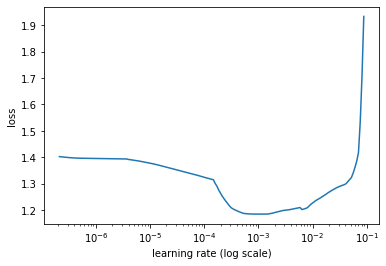

In [ ]:
learner.lr_find(show_plot = True, max_epochs = 5)

In [ ]:
learner.fit_onecycle(5e-5, 5)

begin training using onecycle policy with max lr of 5e-05...
Epoch 1/5
 1/50 [..............................] - ETA: 12:35 - loss: 1.4154 - accuracy: 0.1667 2/50 [>.............................] - ETA: 3:10 - loss: 1.4156 - accuracy: 0.1250  3/50 [>.............................] - ETA: 3:14 - loss: 1.4131 - accuracy: 0.1204 4/50 [=>............................] - ETA: 3:06 - loss: 1.4100 - accuracy: 0.1319 5/50 [==>...........................] - ETA: 3:09 - loss: 1.4064 - accuracy: 0.1589 6/50 [==>...........................] - ETA: 3:03 - loss: 1.4042 - accuracy: 0.1787 7/50 [===>..........................] - ETA: 2:58 - loss: 1.4028 - accuracy: 0.1906 8/50 [===>..........................] - ETA: 2:53 - loss: 1.4014 - accuracy: 0.2006 9/50 [====>.........................] - ETA: 2:48 - loss: 1.4002 - accuracy: 0.209210/50 [=====>........................] - ETA: 2:53 - loss: 1.3991 - accuracy: 0.214911/50 [=====>........................] - ETA: 2:48 - loss: 1.3977 - accuracy: 0.222912/50 [======>.......................] - ETA: 2:42 - loss: 1.3963 - accuracy: 0.232113/50 [======>.......................] - ETA: 2:37 - loss: 1.3951 - accuracy: 0.239914/50 [=======>......................] - ETA: 2:32 - loss: 1.3936 - accuracy: 0.248315/50 [========>.....................] - ETA: 2:27 - loss: 1.3918 - accuracy: 0.257716/50 [========>.....................] - ETA: 2:22 - loss: 1.3902 - accuracy: 0.266317/50 [=========>....................] - ETA: 2:17 - loss: 1.3886 - accuracy: 0.274318/50 [=========>....................] - ETA: 2:12 - loss: 1.3869 - accuracy: 0.282219/50 [==========>...................] - ETA: 2:08 - loss: 1.3854 - accuracy: 0.289020/50 [===========>..................] - ETA: 2:04 - loss: 1.3840 - accuracy: 0.295421/50 [===========>..................] - ETA: 1:59 - loss: 1.3825 - accuracy: 0.301422/50 [============>.................] - ETA: 1:55 - loss: 1.3811 - accuracy: 0.307023/50 [============>.................] - ETA: 1:50 - loss: 1.3798 - accuracy: 0.311924/50 [=============>................]

In [ ]:
learner.view_top_losses(n=1, preproc=t)

----------
id:16 | loss:3.69 | true:Sound Quality | pred:Other)

In [ ]:
learner.model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
distilbert (TFDistilBertMain multiple 66362880 
_________________________________________________________________
pre_classifier (Dense) multiple 590592 
_________________________________________________________________
classifier (Dense) multiple 3076 
_________________________________________________________________
dropout_39 (Dropout) multiple 0 
=================================================================
Total params: 66,956,548
Trainable params: 66,956,548
Non-trainable params: 0
_________________________________________________________________

In [ ]:
learner.validate(print_report=True)

precision recall f1-score support

 0 0.87 0.93 0.90 14
 1 0.95 0.91 0.93 23
 2 0.78 0.93 0.85 46
 3 0.88 0.41 0.56 17

 accuracy 0.84 100
 macro avg 0.87 0.80 0.81 100
weighted avg 0.85 0.84 0.83 100

Out[21]: array([[13, 0, 1, 0],
 [ 0, 21, 2, 0],
 [ 2, 0, 43, 1],
 [ 0, 1, 9, 7]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

# Run hugging face classification on only Sound Quality, Connectivity, or Battery/Rechargeability labels (no other)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(reviewsNoOther['Text'], reviewsNoOther['Label'],test_size=0.25,random_state=42)

MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=list(set(list(y_train))))

trn = t.preprocess_train(list(X_train), list(y_train))
val = t.preprocess_test(list(X_test), list(y_test))

/local_disk0/.ephemeral_nfs/envs/pythonEnv-4251f7e8-fb08-4092-a56f-772e25e37f4d/lib/python3.8/site-packages/ktrain/text/preprocessor.py:420: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
 warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')
preprocessing train...
language: en
train sequence lengths:
	mean : 90
	95percentile : 206
	99percentile : 390
/local_disk0/.ephemeral_nfs/envs/pythonEnv-4251f7e8-fb08-4092-a56f-772e25e37f4d/lib/python3.8/site-packages/ktrain/utils.py:600: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
 if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')
██Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 97
	95percentile : 180
	99percentile : 240
██

In [ ]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
 1/22 [>.............................] - ETA: 5:53 - loss: 1.1638 - accuracy: 0.1667 2/22 [=>............................] - ETA: 2:31 - loss: 1.1613 - accuracy: 0.1667 3/22 [===>..........................] - ETA: 2:00 - loss: 1.1551 - accuracy: 0.1667 4/22 [====>.........................] - ETA: 1:48 - loss: 1.1535 - accuracy: 0.1563 5/22 [=====>........................] - ETA: 1:38 - loss: 1.1501 - accuracy: 0.1650 6/22 [=======>......................] - ETA: 1:30 - loss: 1.1463 - accuracy: 0.1792 7/22 [========>.....................] - ETA: 1:23 - loss: 1.1431 - accuracy: 0.1910 8/22 [=========>....................] - ETA: 1:18 - loss: 1.1395 - accuracy: 0.2062 9/22 [===========>..................] - ETA: 1:15 - loss: 1.1369 - accuracy: 0.216210/22 [============>.................] - ETA: 1:08 - loss: 1.1342 - accuracy: 0.227911/22 [==============>...............] - ETA: 1:02 - loss: 1.1314 - accuracy: 0.240212/22 [===============>..............] - ETA: 56s - loss: 1.1289 - accuracy: 0.2515 13/22 [================>.............] - ETA: 50s - loss: 1.1270 - accuracy: 0.260714/22 [==================>...........] - ETA: 44s - loss: 1.1254 - accuracy: 0.268515/22 [===================>..........] - ETA: 38s - loss: 1.1240 - accuracy: 0.275016/22 [====================>.........] - ETA: 32s - loss: 1.1230 - accuracy: 0.280017/22 [======================>.......] - ETA: 27s - loss: 1.1221 - accuracy: 0.284318/22 [=======================>......] - ETA: 21s - loss: 1.1212 - accuracy: 0.288519/22 [========================>.....] - ETA: 16s - loss: 1.1202 - accuracy: 0.293220/22 [==========================>...] - ETA: 10s - loss: 1.1196 - accuracy: 0.296421/22 [===========================>..] - ETA: 5s - loss: 1.1190 - accuracy: 0.2993 22/22 [==============================] - ETA: 0s - loss: 1.1184 - accuracy: 0.302322/22 [==============================] - 130s 5s/step - loss: 1.1178 - accuracy: 0.3049
Epoch 2/5
 1/22 [>.............................] - ETA: 1:28 - loss: 1.0738 - accuracy: 0.6000

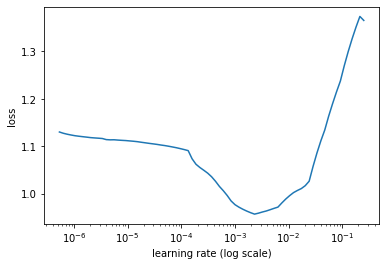

In [ ]:
learner.lr_find(show_plot = True, max_epochs = 5)

In [ ]:
learner.fit_onecycle(5e-5, 5)

begin training using onecycle policy with max lr of 5e-05...
Epoch 1/5
 1/23 [>.............................] - ETA: 5:54 - loss: 1.1181 - accuracy: 0.3333 2/23 [=>............................] - ETA: 2:16 - loss: 1.1205 - accuracy: 0.2917 3/23 [==>...........................] - ETA: 2:15 - loss: 1.1179 - accuracy: 0.3056 4/23 [====>.........................] - ETA: 2:21 - loss: 1.1178 - accuracy: 0.3125 5/23 [=====>........................] - ETA: 2:12 - loss: 1.1173 - accuracy: 0.3167 6/23 [======>.......................] - ETA: 2:04 - loss: 1.1158 - accuracy: 0.3194 7/23 [========>.....................] - ETA: 1:57 - loss: 1.1137 - accuracy: 0.3282 8/23 [=========>....................] - ETA: 1:49 - loss: 1.1120 - accuracy: 0.3341 9/23 [==========>...................] - ETA: 1:42 - loss: 1.1105 - accuracy: 0.340210/23 [============>.................] - ETA: 1:36 - loss: 1.1086 - accuracy: 0.346211/23 [=============>................] - ETA: 1:32 - loss: 1.1063 - accuracy: 0.351912/23 [==============>...............] - ETA: 1:23 - loss: 1.1046 - accuracy: 0.356113/23 [===============>..............] - ETA: 1:15 - loss: 1.1026 - accuracy: 0.360314/23 [=================>............] - ETA: 1:08 - loss: 1.1009 - accuracy: 0.362615/23 [==================>...........] - ETA: 1:00 - loss: 1.0992 - accuracy: 0.366616/23 [===================>..........] - ETA: 52s - loss: 1.0980 - accuracy: 0.3704 17/23 [=====================>........] - ETA: 44s - loss: 1.0970 - accuracy: 0.374018/23 [======================>.......] - ETA: 37s - loss: 1.0959 - accuracy: 0.376319/23 [=======================>......] - ETA: 29s - loss: 1.0948 - accuracy: 0.378220/23 [=========================>....] - ETA: 22s - loss: 1.0937 - accuracy: 0.379721/23 [==========================>...] - ETA: 15s - loss: 1.0930 - accuracy: 0.380222/23 [===========================>..] - ETA: 7s - loss: 1.0926 - accuracy: 0.3798 23/23 [==============================] - ETA: 0s - loss: 1.0922 - accuracy: 0.378823/23 [==============================] - 188s 8s/step - los

In [ ]:
learner.view_top_losses(n=1, preproc=t)

----------
id:9 | loss:3.65 | true:Connectivity | pred:Sound Quality)

In [ ]:
learner.model.summary()

Model: "tf_distil_bert_for_sequence_classification_3"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
distilbert (TFDistilBertMain multiple 66362880 
_________________________________________________________________
pre_classifier (Dense) multiple 590592 
_________________________________________________________________
classifier (Dense) multiple 2307 
_________________________________________________________________
dropout_79 (Dropout) multiple 0 
=================================================================
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________

In [ ]:
learner.validate(print_report=True)

precision recall f1-score support

 0 1.00 0.90 0.95 20
 1 0.94 0.94 0.94 17
 2 0.82 1.00 0.90 9

 accuracy 0.93 46
 macro avg 0.92 0.95 0.93 46
weighted avg 0.94 0.93 0.94 46

Out[29]: array([[18, 1, 1],
 [ 0, 16, 1],
 [ 0, 0, 9]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)